<a href="https://colab.research.google.com/github/m-stoeckel/biofid-document-image-segmentation/blob/master/DocumentImageSegementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torchnet torchvision
!git clone https://github.com/m-stoeckel/biofid-document-image-segmentation.git

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image,ImageFilter,ImageOps,ImageColor,ImageMath
import cv2
import glob
import re
import os
import matplotlib.pyplot as plt
from typing import *

print(torch.__version__)

is_gpu = torch.cuda.is_available()
print("GPU is available:", is_gpu)
device = torch.device("cuda" if is_gpu else "cpu")

1.1.0
GPU is available: True


In [0]:
def binarize_image(img, threshold = 32):
  arr = np.array(img.convert('L'))
  return binarize_array(arr, threshold)


def binarize_array(arr, threshold = 175, invert = True):
  t = int(threshold*255) if type(float) is int and threshold <= 1. else threshold
  for i in range(len(arr)):
    for j in range(len(arr[0])):
      arr[i][j] = 1 if arr[i][j] <= t and invert else 0
  return torch.tensor(arr, dtype=torch.bool)


def clear_axs(axs):
  for ax in axs: 
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])


label_colors = np.array([(0, 0, 0),  # 0=background
                          # 1=Text, 2=Image/Table Label, 3=Image/Table, 4=Page
                          (255,0,0),(255,0,255),(0,0,255),(0,255,0)])
  
def decode_segmap(image, nc=5):
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
   
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
     
  rgb = np.stack([r, g, b], axis=2)
  return rgb

def decode_segmaps(tensors: torch.Tensor, nc=5):
  ret_images = []
  for tnsr in tensors:
    ret_images.append(decode_segmap(tnsr.squeeze().numpy(), nc))
  return ret_images

def decode_segmaps_tensor(tensors: torch.Tensor, nc=5):
  ret_images = torch.empty(tensors.size(0),3,tensors.size(-2),tensors.size(-2))
  for i in range(tensors.size(0)):
    tnsr = decode_segmap(tensors[0].squeeze().numpy(), nc)
    ret_images[i] = torch.tensor(tnsr.transpose(2,0,1))
  return ret_images

def encode_segmap(image, nc=5):
  arr = np.zeros((image.shape[0], image.shape[1]), dtype=int)

  # create foreground layers
  for l in range(1, len(label_colors)):
    c = label_colors[l]
    idx = cv2.inRange(image, c, c) == 255
    arr[idx] = l
    
  return torch.tensor(arr)


def resize_numpy(i, s):
  return np.array(cv2.resize(i, s))

In [0]:
# x_in, x_bin, y_in = [], [], []

# for f in sorted(glob.glob('/content/biofid-document-image-segmentation/data/train/*_*.png')):
#   if f.endswith('raw.png'):
#     x_in.append(Image.open(f).convert("RGB"))
#     x_bin.append(Image.open(f).convert('L'))
#   elif f.endswith('mask.png'):
#     y_in.append(Image.open(f).convert("RGB"))
#   else:
#     pass

# fig, axs = plt.subplots(3,3, figsize=(8,12))
# clear_axs(np.reshape(axs, (9)))
# for i in range(3):
#   axs[i][0].imshow(x_in[i])
#   axs[i][1].imshow(x_bin[i].convert('RGB'))
#   axs[i][2].imshow(y_in[i])
# fig.tight_layout()
# plt.show()

# img = cv2.cvtColor(cv2.imread('/content/9028552_mask.png'), cv2.COLOR_BGR2RGB)
# red = (255,0,0)
# plt.imshow(img)
# plt.show()
# mask = cv2.inRange(img, red, red)
# print(mask.shape)
# plt.imshow(mask, cmap='gray')
# plt.show()

In [0]:
# toTensor = T.ToTensor()
# dim_y = 600
# dim_x = 400
# x_train = torch.empty(3,3,dim_y,dim_x)
# x_bin = torch.empty(3,1,1200,800)
# for i, img in enumerate(x_in):
#   x_train[i] = toTensor(img.resize((dim_x,dim_y), Image.LANCZOS))
#   x_bin[i] = binarize_image(img.resize((800,1200), Image.LANCZOS), 175)
#   y_pre = torch.empty(3,1,1200,800)
  
# for i, img in enumerate(y_in):
#   y_pre[i] = encode_segmap(np.array(img.resize((800,1200), Image.LANCZOS)))

# y_train = torch.mul(x_bin, y_pre)
# x_bin = y_train.gt(0)

# print(str(x_bin[0][0].numpy()[590:610,400]))
# print(str(y_pre[0][0].numpy()[590:610,400]))
# print(str(y_train[0][0].numpy()[590:610,400]))
# print()
# print(str(x_bin[1][0].numpy()[590:610,400]))
# print(str(y_pre[1][0].numpy()[590:610,400]))
# print(str(y_train[1][0].numpy()[590:610,400]))

In [0]:
class BIOfidDataset(Dataset):
    def __init__(self, path, threshold=175./255., x_size=(600,400), y_size=(600,400),
                 use_x_bin=False, concat_x_bin=False, classes=5):
        self.path = path
        self.x_size = x_size
        self.y_size = y_size
        self.threshold = threshold
        self.classes = classes
        self.use_x_bin = use_x_bin
        self.concat_x_bin = concat_x_bin

        image_paths = glob.glob(os.path.join(path,'*_*.png'))
        self.image_ids = list(set(map(
            lambda p: re.findall(r'^(.+)_[a-z]+.png$', os.path.split(p)[1])[0],
            image_paths))
        )
        del image_paths


        self.transformXinput = T.Compose(
            [T.Resize(self.x_size,Image.BILINEAR),
             lambda i: T.functional.adjust_contrast(i, 2),
             T.ToTensor()
            ])
        self.transformXbin = T.Compose(
            [T.Resize(self.x_size,Image.BILINEAR),
             lambda i: T.functional.adjust_contrast(i, 2),
             T.Grayscale(),
             T.ToTensor(),
             lambda x: x <= self.threshold,
             lambda x: x.float()])
        self.transformYinput = T.Compose(
            [T.Resize(self.y_size,Image.BILINEAR),
             lambda p: np.array(p),
             lambda x: encode_segmap(x, self.classes)])
        self.transformYbin = T.Compose(
            [T.Resize(self.y_size,Image.BILINEAR),
             T.Grayscale(),
             T.ToTensor(),
             lambda x: x <= self.threshold,
             lambda x: x.float()])

    def __getitem__(self, index):
        x_in = Image.open(os.path.join(self.path,self.image_ids[index]+'_raw.png')).convert('RGB')
        y_in = Image.open(os.path.join(self.path,self.image_ids[index]+'_target.png')).convert('RGB')

        # generate input tensor
        if not self.use_x_bin:
          x_train = self.transformXinput(x_in)
          if self.concat_x_bin:
            # concatenate the binarized input as 4. channel
            x_bin = self.transformXbin(x_in)
            x_train = torch.cat([x_train, x_bin], dim=0)
        else:
          x_train = self.transformXbin(x_in)

        # generate target tensors
        y_bin = self.transformYbin(x_in)
        y_raw = self.transformYinput(y_in)

        # clip to pixels covered by an annotation
        y_train = torch.mul(y_raw.float(), y_bin).long()
    
        return x_train, y_train, y_bin, y_raw, x_in, y_in

    def __len__(self):
      return len(self.image_ids)

    def len(self):
      return self.__len__()

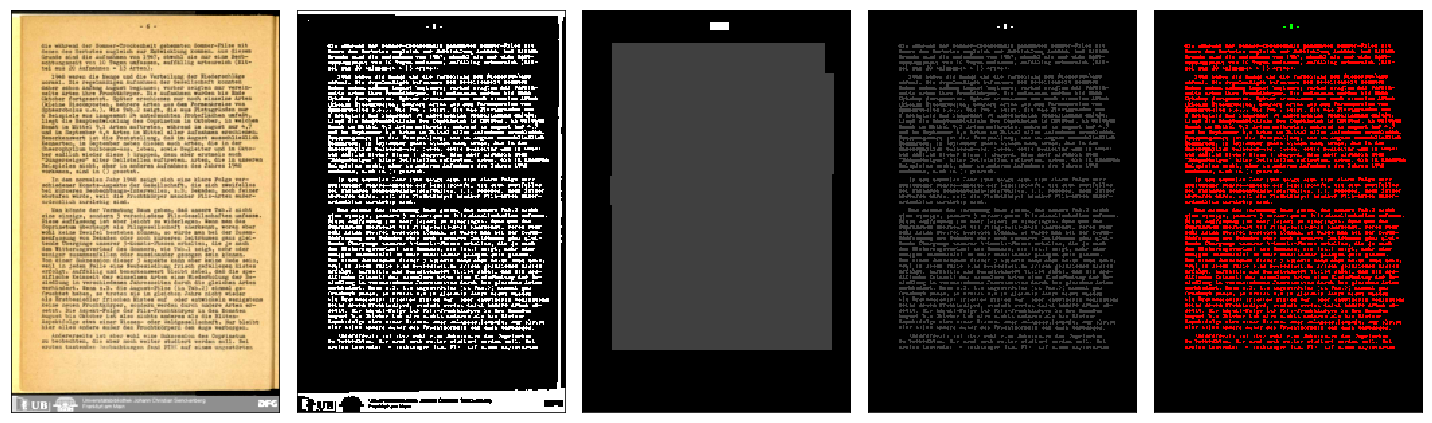

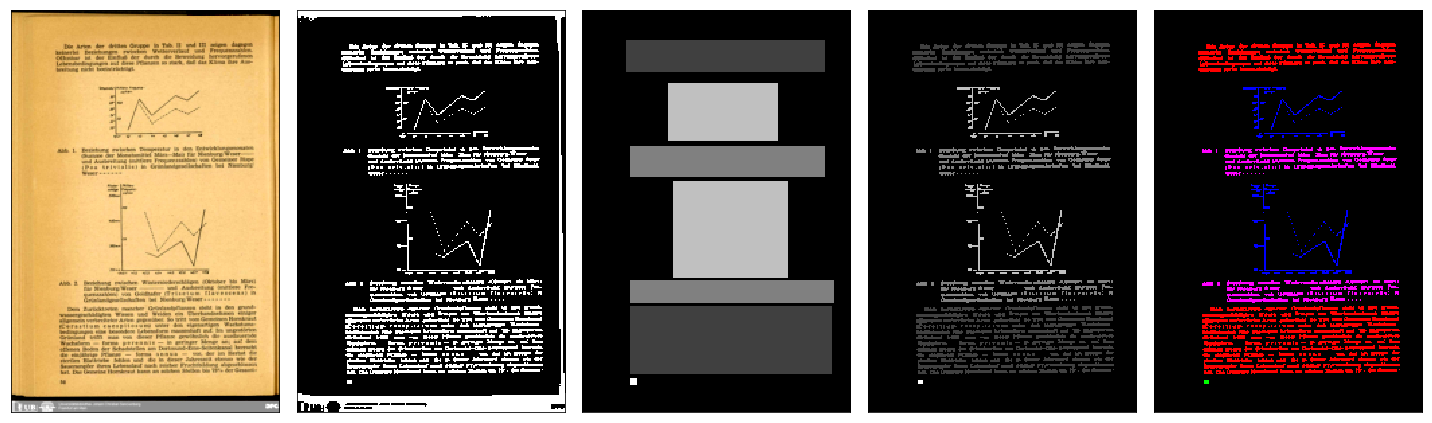

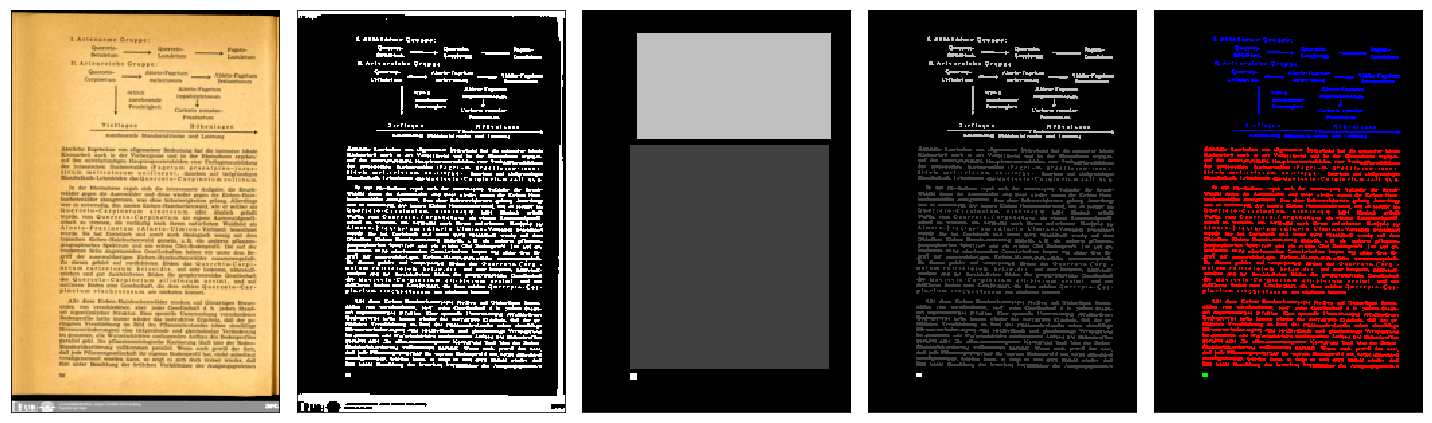

torch.Size([3, 3, 300, 200]) torch.Size([3, 1, 300, 200]) torch.Size([3, 1, 300, 200])


In [0]:
img_size=(300,200)
num_classes = len(label_colors)
concat_x_bin = False
in_channels = 3 if not concat_x_bin else 4
dataset = BIOfidDataset(path='/content/biofid-document-image-segmentation/train/',
                        x_size=img_size, y_size=img_size, classes=num_classes,
                        concat_x_bin=concat_x_bin)
l = dataset.len()

x_train = torch.empty(l,in_channels,img_size[0],img_size[1])
y_bin = torch.empty(l,1,img_size[0],img_size[1])
y_train = torch.empty(l,1,img_size[0],img_size[1])
y_raw = torch.empty(l,1,img_size[0],img_size[1])

transform = T.Compose([T.Resize(img_size),
                       T.ToTensor()])

for i in range(l):
  xt, yt, yb, yr, x_in, y_in = dataset[i]
  x_train[i], y_train[i], y_bin[i], y_raw[i] = xt, yt, yb, yr

  fig, axs = plt.subplots(1,5, figsize=(20,18))
  clear_axs(axs)
  fig.tight_layout()
  axs[0].imshow(xt.numpy().transpose(1,2,0))
  axs[1].imshow(yb.float().squeeze().numpy(), cmap='gray')
  axs[2].imshow(yr.float().numpy(), cmap='gray')
  axs[3].imshow(yt.float().squeeze().numpy(), cmap='gray')
  y_enc = yt.gt(0).float().mul(transform(y_in))
  axs[4].imshow(y_enc.numpy().transpose(1,2,0), cmap='gray')
  plt.show()

print(x_train.shape, y_train.shape, y_bin.shape)

In [0]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, mask=None):
    """
    Evaluates a model's top k accuracy

    Parameters:
        output (torch.autograd.Variable): model output
        target (torch.autograd.Variable): ground-truths/labels
        topk (list): list of integers specifying top-k precisions
            to be computed

    Returns:
        float: percentage of correct predictions
    """

    batch_size = target.size(0)

    pred = torch.argmax(output.detach(), dim=1)
    correct = pred.eq(target).float()
    if mask is not None:
      correct = correct.mul(mask)

    return correct.sum().div(target.numel())

In [0]:
DEBUG = False

class SmallResNet(nn.Module):
  """ Document Image Segemenation CNN based on SegNET. """
  def __init__(self, num_cls=5, out_dim=(600,400), in_channels=3):
    super(SmallResNet, self).__init__()
    self.classes = num_cls
    self.out_dim = out_dim
    self.in_channels = in_channels

    # Encoder
    self.encoder_00 = nn.Sequential(
        nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )
    self.encoder_01 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )

    self.encoder_10 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128)
    )
    self.encoder_11 = nn.Sequential(
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128)
    )

    self.encoder_20 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256)
    )
    self.encoder_21 = nn.Sequential(
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256)
    )

    self.encoder_30 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512)
    )
    self.encoder_31 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512)
    )
    self.encoder_32 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512)
    )

    # Decoder
    self.decoder_32 = nn.Sequential(
        nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512)
    )
    self.decoder_31 = nn.Sequential(
        nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512)
    )
    self.decoder_30 = nn.Sequential(
        nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256)
    )

    self.decoder_21 = nn.Sequential(
        nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256)
    )
    self.decoder_20 = nn.Sequential(
        nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128)
    )

    self.decoder_11 = nn.Sequential(
        nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128)
    )
    self.decoder_10 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )

    self.decoder_01 = nn.Sequential(
        nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )
    self.decoder_00 = nn.Sequential(
        nn.ConvTranspose2d(64, self.classes, kernel_size=3, padding=1)
    )

  def forward(self, x_in):
    # encode
    dim_0 = x_in.size()
    x_00 = F.relu(self.encoder_00(x_in))
    x_01 = F.relu(self.encoder_01(x_00))
    x_0, indices_0 = F.max_pool2d(x_01, kernel_size=2, stride=2, return_indices=True)

    dim_1 = x_0.size()
    x_10 = F.relu(self.encoder_10(x_0))
    x_11 = F.relu(self.encoder_11(x_10))
    x_1, indices_1 = F.max_pool2d(x_11, kernel_size=2, stride=2, return_indices=True)
    
    dim_2 = x_1.size()
    x_20 = F.relu(self.encoder_20(x_1))
    x_21 = F.relu(self.encoder_21(x_20))
    x_2, indices_2 = F.max_pool2d(x_21, kernel_size=2, stride=2, return_indices=True)
    
    dim_3 = x_2.size()
    x_30 = F.relu(self.encoder_30(x_2))
    x_31 = F.relu(self.encoder_31(x_30))
    x_32 = F.relu(self.encoder_32(x_31))
    x_3, indices_3 = F.max_pool2d(x_32, kernel_size=2, stride=2, return_indices=True)

    if DEBUG:
      print("dim_0: {}".format(dim_0))
      print("dim_1: {}".format(dim_1))
      print("dim_2: {}".format(dim_2))
      print("dim_3: {}".format(dim_3))
    
    dim_d = x_3.size()

    # decode
    x_3d = F.max_unpool2d(x_3, indices_3, kernel_size=2, stride=2, output_size=dim_3)
    x_32d = F.relu(self.decoder_32(x_3d))
    x_31d = F.relu(self.decoder_31(x_32d))
    x_30d = F.relu(self.decoder_30(x_31d))
    dim_3d = x_30d.size()

    x_2d = F.max_unpool2d(x_30d, indices_2, kernel_size=2, stride=2, output_size=dim_2)
    x_21d = F.relu(self.decoder_21(x_2d))
    x_20d = F.relu(self.decoder_20(x_21d))
    dim_2d = x_20d.size()

    x_1d = F.max_unpool2d(x_20d, indices_1, kernel_size=2, stride=2, output_size=dim_1)
    x_11d = F.relu(self.decoder_11(x_1d))
    x_10d = F.relu(self.decoder_10(x_11d))
    dim_1d = x_10d.size()

    x_0d = F.max_unpool2d(x_10d, indices_0, kernel_size=2, stride=2, output_size=dim_0)
    x_01d = F.relu(self.decoder_01(x_0d))
    x_00d = F.relu(self.decoder_00(x_01d))
    dim_0d = x_00d.size()

    if DEBUG:
      print("dim_d: {}".format(dim_d))
      print("dim_3d: {}".format(dim_3d))
      print("dim_2d: {}".format(dim_2d))
      print("dim_1d: {}".format(dim_1d))
      print("dim_0d: {}".format(dim_0d))

    x_softmax = F.softmax(x_00d, dim=1)

    return x_softmax

In [0]:
DEBUG = False

class InterpolateResNet(nn.Module):
  """ Document Image Segemenation CNN based on SegNET. """
  def __init__(self, num_cls=5, out_dim=(600,400), in_channels=3):
    super(InterpolateResNet, self).__init__()
    self.classes = num_cls
    self.out_dim = out_dim
    self.in_channels = in_channels

    # Encoder
    self.encoder_00 = nn.Sequential(
        nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )
    self.encoder_01 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )

    self.encoder_10 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128)
    )
    self.encoder_11 = nn.Sequential(
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128)
    )

    self.encoder_20 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256)
    )
    self.encoder_21 = nn.Sequential(
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256)
    )

    self.encoder_30 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512)
    )
    self.encoder_31 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512)
    )
    self.encoder_32 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512)
    )

    # Decoder
    self.decoder_32 = nn.Sequential(
        nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512)
    )
    self.decoder_31 = nn.Sequential(
        nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512)
    )
    self.decoder_30 = nn.Sequential(
        nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256)
    )

    self.decoder_21 = nn.Sequential(
        nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256)
    )
    self.decoder_20 = nn.Sequential(
        nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128)
    )

    self.decoder_11 = nn.Sequential(
        nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128)
    )
    self.decoder_10 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )

    self.decoder_01 = nn.Sequential(
        nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )
    self.decoder_00 = nn.Sequential(
        nn.ConvTranspose2d(64, self.classes, kernel_size=3, padding=1)
    )

  def forward(self, x_in):
    # encode
    dim_0 = x_in.size()
    x_00 = F.relu(self.encoder_00(x_in))
    x_01 = F.relu(self.encoder_01(x_00))
    x_0, indices_0 = F.max_pool2d(x_01, kernel_size=2, stride=2, return_indices=True)

    dim_1 = x_0.size()
    x_10 = F.relu(self.encoder_10(x_0))
    x_11 = F.relu(self.encoder_11(x_10))
    x_1, indices_1 = F.max_pool2d(x_11, kernel_size=2, stride=2, return_indices=True)
    
    dim_2 = x_1.size()
    x_20 = F.relu(self.encoder_20(x_1))
    x_21 = F.relu(self.encoder_21(x_20))
    x_2, indices_2 = F.max_pool2d(x_21, kernel_size=2, stride=2, return_indices=True)
    
    dim_3 = x_2.size()
    x_30 = F.relu(self.encoder_30(x_2))
    x_31 = F.relu(self.encoder_31(x_30))
    x_32 = F.relu(self.encoder_32(x_31))
    x_3, indices_3 = F.max_pool2d(x_32, kernel_size=2, stride=2, return_indices=True)

    if DEBUG:
      print("dim_0: {}".format(dim_0))
      print("dim_1: {}".format(dim_1))
      print("dim_2: {}".format(dim_2))
      print("dim_3: {}".format(dim_3))
    
    dim_d = x_3.size()

    # decode
    # x_3d = F.max_unpool2d(x_3, indices_3, kernel_size=2, stride=2, output_size=dim_3)
    x_3d = F.interpolate(x_3, dim_3)
    x_32d = F.relu(self.decoder_32(x_3d))
    x_31d = F.relu(self.decoder_31(x_32d))
    x_30d = F.relu(self.decoder_30(x_31d))
    dim_3d = x_30d.size()

    # x_2d = F.max_unpool2d(x_30d, indices_2, kernel_size=2, stride=2, output_size=dim_2)
    x_2d = F.interpolate(x_30d, dim_2)
    x_21d = F.relu(self.decoder_21(x_2d))
    x_20d = F.relu(self.decoder_20(x_21d))
    dim_2d = x_20d.size()

    # x_1d = F.max_unpool2d(x_20d, indices_1, kernel_size=2, stride=2, output_size=dim_1)
    x_1d = F.interpolate(x_20d, dim_1)
    x_11d = F.relu(self.decoder_11(x_1d))
    x_10d = F.relu(self.decoder_10(x_11d))
    dim_1d = x_10d.size()

    # x_0d = F.max_unpool2d(x_10d, indices_0, kernel_size=2, stride=2, output_size=dim_0)
    x_0d = F.interpolate(x_10d, dim_0)
    x_01d = F.relu(self.decoder_01(x_0d))
    x_00d = F.relu(self.decoder_00(x_01d))
    dim_0d = x_00d.size()

    if DEBUG:
      print("dim_d: {}".format(dim_d))
      print("dim_3d: {}".format(dim_3d))
      print("dim_2d: {}".format(dim_2d))
      print("dim_1d: {}".format(dim_1d))
      print("dim_0d: {}".format(dim_0d))

    x_softmax = F.softmax(x_00d, dim=1)

    return x_softmax

In [0]:
def train(model, criterion, optimizer, use_bin_mask = True, epochs = 5, iterations = 50):
  inp = x_train.to(device)
  if use_bin_mask:
    target = y_train.squeeze().long().to(device)
    mask = y_bin.float().to(device)
  else:
    target = y_raw.squeeze().long().to(device)
  
  losses = AverageMeter()
  prec = AverageMeter()

  output = None
  model.train()
  for i in range(epochs):
    for j in range(iterations):
      output = model(inp)
      if use_bin_mask:
        output = output.mul(mask)

      loss = criterion(output, target)
      losses.update(loss.item(), inp.size(0))

      acc = 0.
      if use_bin_mask:
        acc = accuracy(output, target, mask)
      else:
        acc = accuracy(output, target)
      prec.update(acc.item(), inp.size(0))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print(f'\rEpoch {i+1: 03d} Iteration {j+1: 04d}', 
            f'Loss {losses.val:.4f} ({losses.avg:.4f})',
            f'Prec {prec.val:.3f} ({prec.avg:.3f})',
            end='')

    # End of epoch debug
    t = torch.argmax(output.detach().cpu(), dim=1)
    if use_bin_mask:
      t = t.float().mul(y_bin.squeeze().float()).to(torch.int16)
    print(f"\nClasses: {np.unique(t)}")
    imgs = decode_segmaps(t.split(1, dim=0))
    fig, axs = plt.subplots(1,3, figsize=(6,9))
    fig.tight_layout()
    clear_axs(axs)
    axs[0].imshow(imgs[0])
    axs[1].imshow(imgs[1])
    axs[2].imshow(imgs[2])
    plt.show()

tensor([ 1.8564,  0.6816,  4.5443,  4.1417, 10.2191])
Epoch  01 Iteration  050 Loss 1.5510 (1.5750) Prec 0.665 (0.558)
Classes: [0 1 2 3 4]


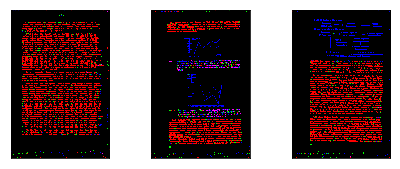

Epoch  02 Iteration  050 Loss 1.5296 (1.5566) Prec 0.700 (0.624)
Classes: [0 1 2 3 4]


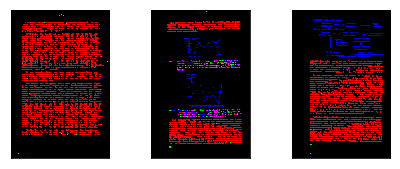

Epoch  03 Iteration  050 Loss 1.5201 (1.5459) Prec 0.704 (0.650)
Classes: [0 1 2 3 4]


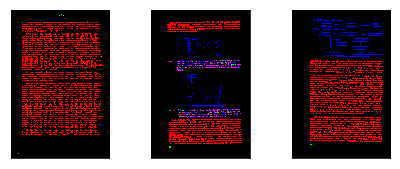

Epoch  04 Iteration  050 Loss 1.5142 (1.5387) Prec 0.706 (0.664)
Classes: [0 1 2 3 4]


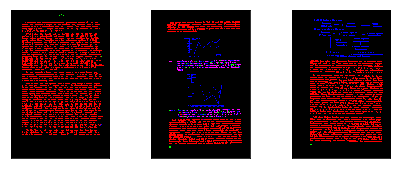

Epoch  05 Iteration  050 Loss 1.5099 (1.5333) Prec 0.707 (0.672)
Classes: [0 1 2 3 4]


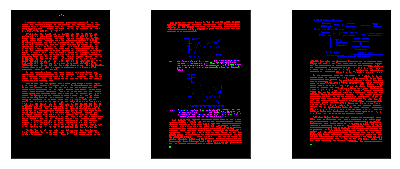

In [0]:
model_small = SmallResNet(in_channels=in_channels, out_dim=img_size).to(device)

log_inv_prob = torch.Tensor(len(label_colors))
for l in range(0, len(label_colors)):
  log_inv_prob[l] = y_train.view(-1).eq(l).float().mul(y_bin.float().view(-1)).sum()
log_inv_prob = torch.div(1.0, log_inv_prob.div(y_bin.view(-1).float().gt(0).sum())).log2()
print(log_inv_prob)
criterion = nn.CrossEntropyLoss(weight=log_inv_prob).to(device)
# criterion = nn.CrossEntropyLoss(weight=F.softmax(log_inv_prob)).to(device)
# optimizer = torch.optim.SGD(model.parameters(),lr=1e-3, momentum=0.9, weight_decay=1e-5)
optimizer = torch.optim.Adagrad(model_small.parameters(),lr=1e-4, lr_decay=1e-5, weight_decay=1e-5)
train(model_small, criterion, optimizer, use_bin_mask = True)


Classes: [0 1 2 3 4]


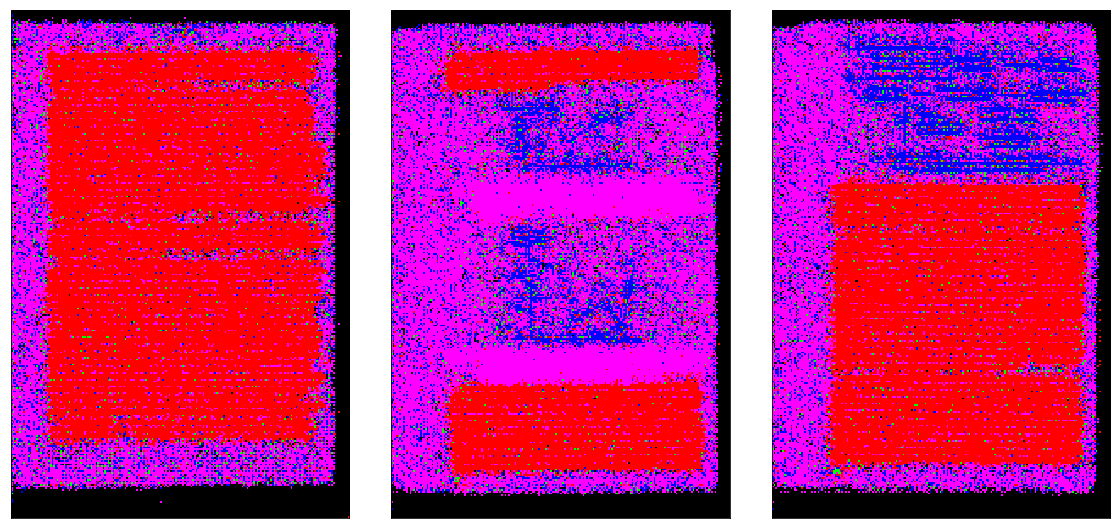

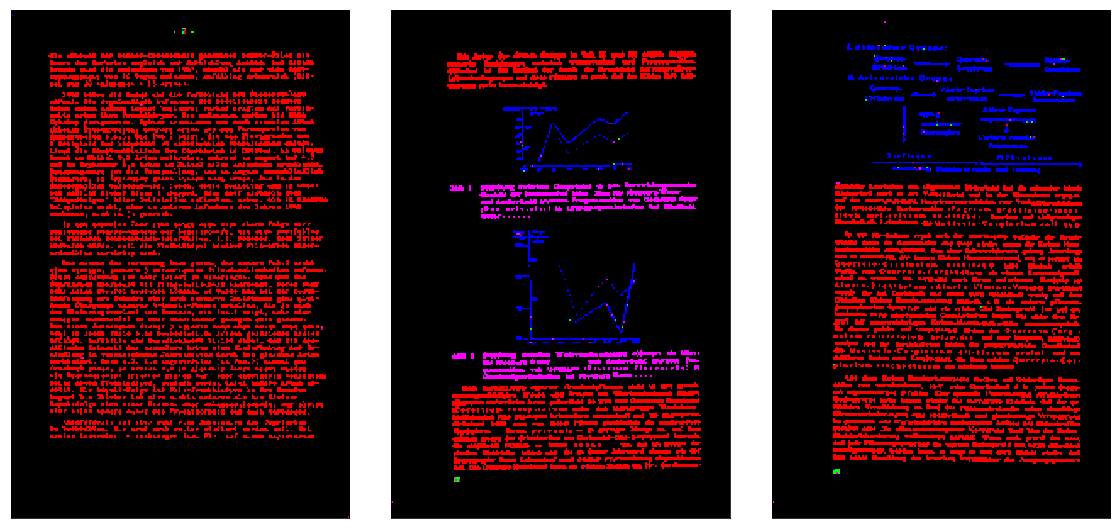

In [0]:
model = model_small
model.eval()

result = model.forward(x_train.to(device))
result = torch.argmax(result.detach().cpu(), dim=1)
print(f"\nClasses: {np.unique(result)}")
imgs = decode_segmaps(result.split(1, dim=0))
fig, axs = plt.subplots(1,3, figsize=(16,12))
fig.tight_layout()
clear_axs(axs)
axs[0].imshow(imgs[0])
axs[1].imshow(imgs[1])
axs[2].imshow(imgs[2])
plt.show()

result = result.float().mul(y_bin.squeeze().float()).to(torch.int16)
imgs = decode_segmaps(result.split(1, dim=0))
fig, axs = plt.subplots(1,3, figsize=(16,12))
fig.tight_layout()
clear_axs(axs)
axs[0].imshow(imgs[0])
axs[1].imshow(imgs[1])
axs[2].imshow(imgs[2])
plt.show()

tensor([ 1.8564,  0.6816,  4.5443,  4.1417, 10.2191])
Epoch  01 Iteration  050 Loss 1.5455 (1.5649) Prec 0.627 (0.553)
Classes: [0 1 2 3 4]


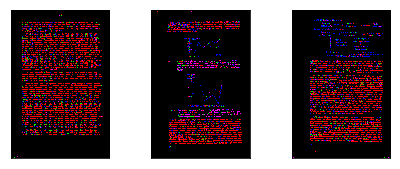

Epoch  02 Iteration  050 Loss 1.5218 (1.5488) Prec 0.688 (0.609)
Classes: [0 1 2 3 4]


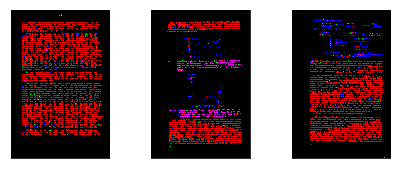

Epoch  03 Iteration  050 Loss 1.5051 (1.5367) Prec 0.706 (0.639)
Classes: [0 1 2 3 4]


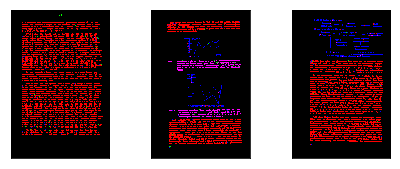

Epoch  04 Iteration  050 Loss 1.4957 (1.5275) Prec 0.712 (0.657)
Classes: [0 1 2 3 4]


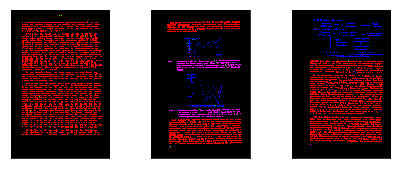

Epoch  05 Iteration  050 Loss 1.4909 (1.5206) Prec 0.714 (0.668)
Classes: [0 1 2 3 4]


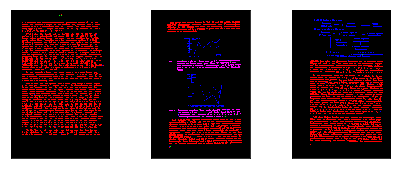

In [0]:
model_interpolate = SmallResNet(in_channels=in_channels, out_dim=img_size).to(device)

label_prob = torch.Tensor(len(label_colors))
yb_flat = y_bin.float().view(-1)
for l in range(0, len(label_colors)):
  label_prob[l] = y_train.view(-1).eq(l).float().mul(yb_flat).sum()
log_inv_prob = torch.div(1.0, label_prob.div(yb_flat.gt(0).sum())).log2()
print(log_inv_prob)
criterion = nn.CrossEntropyLoss(weight=log_inv_prob).to(device)
optimizer = torch.optim.Adagrad(model_interpolate.parameters(),lr=1e-4, lr_decay=1e-5, weight_decay=1e-5)
train(model_interpolate, criterion, optimizer, use_bin_mask = True)


Classes: [0 1 2 3 4]


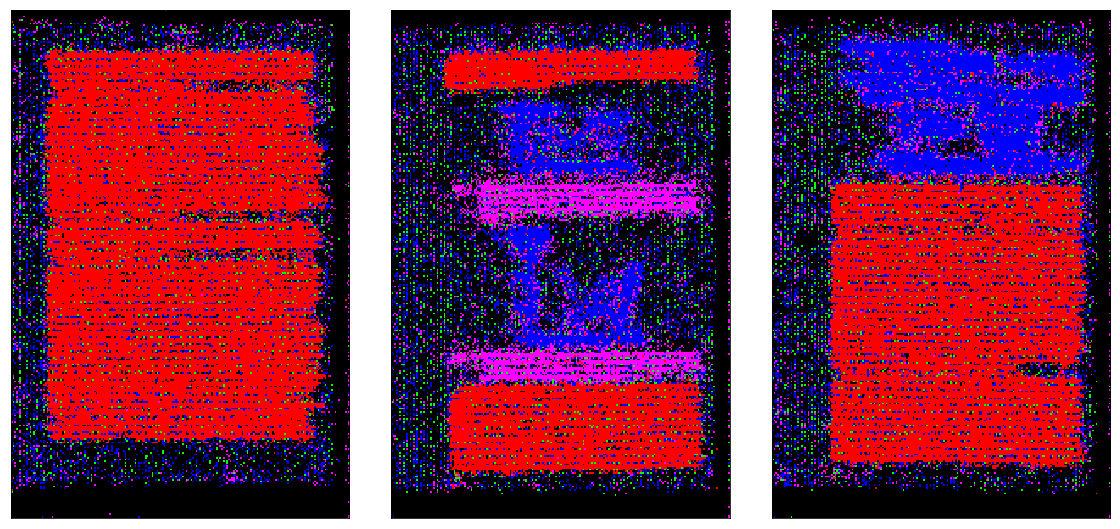

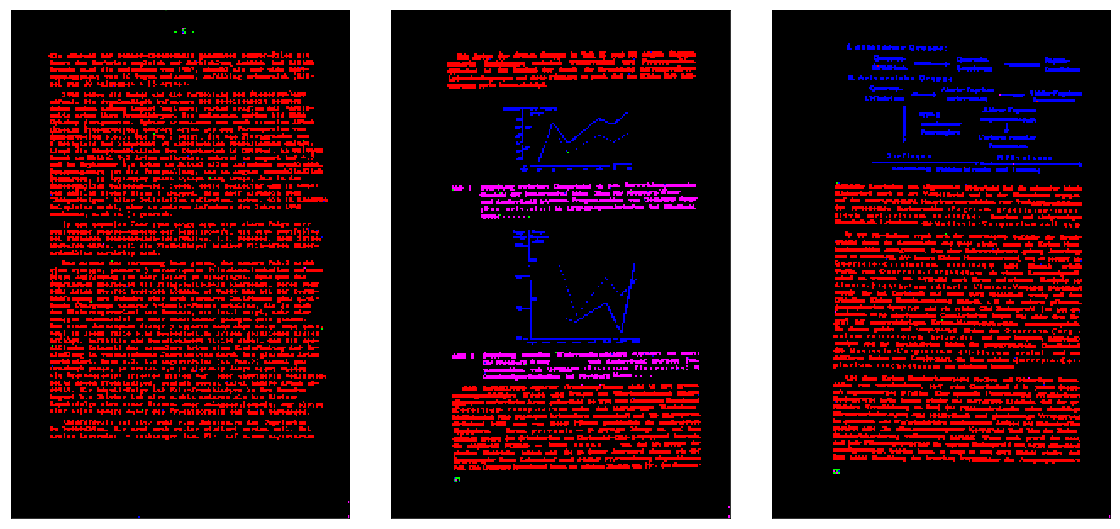

In [0]:
model = model_interpolate
model.eval()

result = model.forward(x_train.to(device))
result = torch.argmax(result.detach().cpu(), dim=1)
print(f"\nClasses: {np.unique(result)}")
imgs = decode_segmaps(result.split(1, dim=0))
fig, axs = plt.subplots(1,3, figsize=(16,12))
fig.tight_layout()
clear_axs(axs)
axs[0].imshow(imgs[0])
axs[1].imshow(imgs[1])
axs[2].imshow(imgs[2])
plt.show()

result = result.float().mul(y_bin.squeeze().float()).to(torch.int16)
imgs = decode_segmaps(result.split(1, dim=0))
fig, axs = plt.subplots(1,3, figsize=(16,12))
fig.tight_layout()
clear_axs(axs)
axs[0].imshow(imgs[0])
axs[1].imshow(imgs[1])
axs[2].imshow(imgs[2])
plt.show()